<a href="https://colab.research.google.com/github/GMISSAGLIA/GM_PyLab/blob/Main/Hodrick_Prescott_and_BIS_III_Credit_To_GDP_Gap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hodrick Prescott and BIS III Credit To GDP Gap: can we  replicate the measure using public data ? 

The Hodrick–Prescott filter extracts a smooth trend (where smoothness is measured as the square of the second difference) from a non-stationary time series separating the Cycle component from the Trend component. 

Depending on how the smoothness factor is calculated, there are two versions of the HP filter:

1)in case the smoothness factor is calculated as the centered second-order difference we have the regular two-sided (HP-2s) which uses information beyond current period t to iter the time series - as consequence, it revises its inference on all observations in the sample as new observations become available - 
then the two-sided HP is the tau that solves the following minimization problem:

$$ 
Min_{\tau }(\sum_{t=1}^{T} \left (y_{t} - \tau_{t} \right )^{2} + \lambda  \sum_{t=2}^{T-1}(\tau_{t+1}-2\tau_{t}+\tau_{t})^{2})
$$ 


2) in case the smoothness factor is calculated as not centered second order difference we have the one-sided (HP-1s) which uses only observations until the current period t to iter the time series - this one is also the regulator's choice because it is attractive for predictive tasks and it doesn't imply the revision of past estimates.  

then the one-sided (HP-1s) is the tau that solves the following minimization problem

$$ 
Min_{\tau }(\sum_{t=1}^{T} \left (y_{t} - \tau_{t} \right )^{2} + \lambda  \sum_{t=3}^{T}(\tau_{t}-2\tau_{t-1}+\tau_{t-2})^{2})
$$ 

To calculate the Countercyclical Capital Buffer requirement Basel III regulation recommends using a Credit-to-GDP Gap measure obtained by applying a one-sided HP filter.

In the following steps we will apply the Hodrick Prescott Filter to the Bankit quarterly data on "Countercyclical Capital Buffer"  to calculate Italy's Credit To GDP Gap; eventually, we will check our application of the Hodrick Prescott Filter comparing our calculated values with the corresponding official ones

[Here](https://www.bancaditalia.it/compiti/stabilita-finanziaria/politica-macroprudenziale/ccyb-2-2022/index.html#:~:text=La%20Banca%20d'Italia%20ha,credito%20e%20PIL%20%C3%A8%20diminuito.) you can download updated data on countercyclical capital buffer and its determinants.


References:

[- Why you should use the Hodrick-Prescott filter – at least to generate credit gaps - - BIS Working Papers - No 744 -](https://www.bis.org/publ/work744.htm)

[- A note on the implementation of a Countercyclical Capital Buffer in Italy -Banca D'Italia -
by Piergiorgio Alessandri, Pierluigi Bologna, Roberta Fiori and Enrico Sette](https://www.bancaditalia.it/pubblicazioni/qef/2015-0278/index.html?com.dotmarketing.htmlpage.language=1)

[ - The credit-to-GDP gap and countercyclical capital buffers: questions and answers - BIS -](https://www.bis.org/publ/qtrpdf/r_qt1403g.htm)

[- Measuring the Credit To GDP GAPS the HODRICK-PRESCOTT filter revisited- Jorge E. Galán](https://www.bde.es/f/webbde/SES/Secciones/Publicaciones/PublicacionesSeriadas/DocumentosOcasionales/19/Files/do1906e.pdf)

[- On adjusting the one sided hodrick prescott filter - Bundesbank -](https://www.bundesbank.de/en/publications/research/discussion-papers/on-adjusting-the-one-sided-hodrick-prescott-filter-828152)

[- How Should Credit Gaps Be Measured? - IMF - ](https://www.imf.org/-/media/Files/Publications/WP/2020/English/wpiea2020006-print-pdf.ashx)

[- Credit-to-GDP Trends and Gaps by Lender- and Credit-type -FED-](https://www.federalreserve.gov/econresdata/notes/feds-notes/2015/credit-to-gdp-trends-and-gaps-by-lender-and-credit-type-20151203.html)

and some critiques:

[-The Unreliability of Credit-to-GDP Ratio Gaps in Real Time: Implications for Countercyclical
Capital Buffers∗ Federal Reserve Board - ](https://www.ijcb.org/journal/ijcb11q4a10.pdf)

[- Why You Should Never Use the Hodrick-Prescott Filter -James D. Hamilton](https://economics.ecu.edu/wp-content/pv-uploads/sites/165/2019/04/20171002-hamilton-seminar-HP_slides.pdf)

[- BIS credit gdp gap and its critiques](https://cepr.org/voxeu/columns/bis-credit-gdp-gap-and-its-critiques)

[- Exploring BIS credit-to-GDP gap critiques:
the Swiss case](https://sjes.springeropen.com/counter/pdf/10.1186/s41937-021-00073-1.pdf)



In [ ]:
colab =True
if colab:
  !pip install pandasql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26784 sha256=e2c0b2e56cc68b04f66dc03b7bb73d20925960788b9ebcd8a2628f335c406428
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql


In [ ]:
import datetime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandasql as ps
from pandasql import sqldf
import warnings
from sklearn import metrics
from statsmodels.tsa.stattools import adfuller
import ipywidgets as widgets
warnings.filterwarnings("ignore")

# Hodrick Prescott -HP- Filter - one and two Sided -

The heuristic approach of Hodrick and Prescott sets λ = 1,600 for quarterly data and that value is  scaled for other frequencIES:
- 6.25 for yearly data, 
- 100 for half-yearly data,
- 129,600 for monthly data, 
- 1600 × 124 for weekly data, 
- 1600 × (365/4) for daily data

To calculate the Credit To GDP Gap Bankit sets λ=400000 

In [ ]:
#One Sided Hodrick Prescott Filter in Python:https://github.com/graemewestwood/HP-Filter

from scipy.linalg import cho_factor, cho_solve
from statsmodels.tools.validation import array_like, PandasWrapper

def hprescott(X, side=2, smooth=1600, freq=''):
    '''
    Hodrick-Prescott filter with the option to use either the standard two-sided 
    or one-sided implementation. The two-sided implementation leads to equivalent
    results as when using the statsmodel.tsa hpfilter function
    
    Parameters
    ----------
    X : array-like
        The time series to filter (1-d), need to add multivariate functionality.
        
    side : int
           The implementation requested. The function will default to the standard
           two-sided implementation.
           
    smooth : float 
            The Hodrick-Prescott smoothing parameter. A value of 1600 is
            suggested for quarterly data. Ravn and Uhlig suggest using a value
            of 6.25 (1600/4**4) for annual data and 129600 (1600*3**4) for monthly
            data. The function will default to using the quarterly parameter (1600).
    freq : str
           Optional parameter to specify the frequency of the data. Will override
           the smoothing parameter and implement using the suggested value from
           Ravn and Uhlig. Accepts annual (a), quarterly (q), or monthly (m)
           frequencies.
    Returns
    -------
    
    cycle : ndarray
            The estimated cycle in the data given side implementation and the 
            smoothing parameter.
            
    trend : ndarray
            The estimated trend in the data given side implementation and the 
            smoothing parameter.
    
    References
    ----------
    Hodrick, R.J, and E. C. Prescott. 1980. "Postwar U.S. Business Cycles: An
        Empirical Investigation." `Carnegie Mellon University discussion
        paper no. 451`.
        
    Meyer-Gohde, A. 2010. "Matlab code for one-sided HP-filters."
        `Quantitative Macroeconomics & Real Business Cycles, QM&RBC Codes 181`.
    
    Ravn, M.O and H. Uhlig. 2002. "Notes On Adjusted the Hodrick-Prescott
        Filter for the Frequency of Observations." `The Review of Economics and
        Statistics`, 84(2), 371-80.
    
    Examples
    --------
    from statsmodels.api import datasets, tsa
    import pandas as pd
    dta = datasets.macrodata.load_pandas().data
    index = pd.DatetimeIndex(start='1959Q1', end='2009Q4', freq='Q')
    dta.set_index(index, inplace=True)
    
    #Run original tsa.filters two-sided hp filter
    cycle_tsa, trend_ts = tsa.filters.hpfilter(dta.realgdp, 1600)
    #Run two-sided implementation
    cycle2, trend2 = hprescott(dta.realgdp, 2, 1600)
    #Run one-sided implementation
    cycle1, trend1 = hprescott(dta.realgdp, 1, 1600)
    '''
    
    #Determine smooth if a specific frequency is given
    if freq == 'q':
        smooth = 1600 #quarterly
    elif freq == 'a':
        smooth = 6.25 #annually
    elif freq == 'm':
        smooth = 129600 #monthly
    elif freq != '':
        print('''Invalid frequency parameter inputted. Defaulting to defined smooth
        parameter value or 1600 if no value was provided.''')
    
    pw = PandasWrapper(X)
    X = array_like(X, 'X', ndim=1)
    T = len(X)
    
    #Preallocate trend array
    trend = np.zeros(len(X))

    #Rearrange the first order conditions of minimization problem to yield matrix
    #First and last two rows are mirrored
    #Middle rows follow same pattern shifting position by 1 each row

    a1 = np.array([1+smooth, -2*smooth, smooth])
    a2 = np.array([-2*smooth, 1+5*smooth, -4*smooth, smooth])
    a3 = np.array([smooth, -4*smooth, 1+6*smooth, -4*smooth, smooth])
    
    Abeg = np.concatenate(([np.append([a1],[0])],[a2]))
    Aend = np.concatenate(([a2[3::-1]], [np.append([0],[a1[2::-1]])]))
    
    Atot = np.zeros((T, T))
    Atot[:2,:4] = Abeg
    Atot[-2:,-4:] = Aend

    for i in range(2, T-2):
        Atot[i,i-2:i+3] = a3

    if (side == 1):
        t = 2
        trend[:t] = X[:t]

        # Third observation minimization problem is as follows	
        r3 = np.array([-2*smooth, 1+4*smooth, -2*smooth])

        Atmp = np.concatenate(([a1, r3], [a1[2::-1]]))
        Xtmp = X[:t+1]

        # Solve the system A*Z = X
        trend[t] = cho_solve(cho_factor(Atmp), Xtmp)[t]

        t += 1

        #Pattern begins with fourth observation
        #Create base A matrix with unique first and last two rows
        #Build recursively larger through time period
        Atmp = np.concatenate(([np.append([a1],[0])],[a2],[a2[3::-1]],[np.append([0],a1[2::-1])]))
        Xtmp = X[:t+1]

        trend[t] = cho_solve(cho_factor(Atmp), Xtmp)[t]

        while (t < T-1):

            t += 1

            Atmp = np.concatenate((Atot[:t-1,:t+1], np.zeros((2, t+1))))
            Atmp[t-1:t+1,t-3:t+1] = Aend

            Xtmp = X[:t+1]
            trend[t] = cho_solve(cho_factor(Atmp), Xtmp)[t]

    elif (side== 2):
        trend = cho_solve(cho_factor(Atot), X)
    else:
        raise ValueError('Side Parameter should be 1 or 2')

    cyclical = X - trend
    
    return pw.wrap(cyclical, append='cyclical'), pw.wrap(trend, append='trend')

In [ ]:
#Functions to calculate the Dickey Fuller stationarity tests

def GM_ADF(series):
      from statsmodels.tsa.stattools import adfuller
      result = adfuller(series, autolag='AIC')
      out={'ADF Statistic':result[0],'P-values':result[1],'Lags':result[2], 'Critical Values':result[4]}
      return out
    
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    pd.options.display.float_format = '{:,.3f}'.format
    print (f'Dickey-Fuller Test for : {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    print(r"The ADF null Hypothesis is: the series is non stationary and it has unitary root")
    if dftest[1] <= 0.05:
        print(f'the pvalue is: p = {dftest[1]:.3f}')
        print(" - we reject the null hypothesis then  we consider the series as stationary")
    else:
        print(f'the pvalue is: p = {dftest[1]:.3f}')
        print(" - we can't reject the null hypothesis then we consider the series as non-stationary")
            
    

##  -  Data Import

In [ ]:
DF_BANKIT = pd.read_excel(r'https://github.com/GMISSAGLIA/GM_PyLab/blob/Main/T_CD_BANKIT.xlsx?raw=true',index_col=[0], parse_dates=[0]) 
DF_BANKIT.head(5)

,CreditGDP_Gap,CreditGDP_GAP_Bankit,CreditGDP,BanksCreditGDP_Gap,BanksCreditGDP_Gap_Bankit,BanksCreditGDP,GDP,BanksCredit,TotalCredit,RE_Price,RE_Price_Gap
Date,,,,,,,,,,,
1990-03-31,0.080569,0.054676,0.617806,0.060389,0.046187,0.476660,691021.0,329382.0,426917.0,94.473798,0.144567
1990-06-30,0.089909,0.061443,0.629625,0.067536,0.050193,0.485594,706007.0,342833.0,444520.0,100.132841,0.187640
1990-09-30,0.073148,0.042299,0.614520,0.060567,0.040248,0.480119,720074.0,345721.0,442501.0,101.315403,0.184223
1990-12-31,0.134403,0.100571,0.681095,0.096187,0.072607,0.519394,730704.0,379523.0,497679.0,104.077958,0.195041
1991-03-31,0.098208,0.062364,0.648344,0.078588,0.052514,0.504586,747403.0,377129.0,484574.0,104.474673,0.183204


In [ ]:
#Cycle_1 = One sided HP GAP and  Cycle_2 = 2 sided HP GAP
#the first one is the variable to compare to the official value
def Calc_HP(DF_IN, VarName, Lambda=1600):
    from statsmodels.tsa.filters.hp_filter import hpfilter
    warnings.filterwarnings("ignore")
    %matplotlib inline 
    DF = DF_IN.copy()
    cycle_2,trend_2= hprescott(DF[VarName], 2, Lambda)
    cycle_1,trend_1= hprescott(DF[VarName], 1, Lambda)
    cycle,trend = hpfilter(DF[VarName], Lambda)
    DF['Cycle'] = cycle
    DF['Trend'] = trend
    DF['Cycle_2'] = cycle_1
    DF['Trend_2'] = trend_1
    DF['Cycle_1'] = cycle_1
    DF['Trend_1'] = trend_1
    DF['Cycle_2'] = cycle_2
    DF['Trend_2'] = trend_2
    return DF

# Hodrick Prescott: calculated vs official

We compare our Credit To GDP gap to the corresponding official value.

As expected our HP-2s is far from the official value all long the interval because the 2 measures are calculated in a different ways.

Otherwise, our HP-1 after the first interval of divergence gradually converges to the official measure; the discordance in the first period is because Official values arise from a deeper time series.

The more the series will lengthen, the more the latest values of our calculation will approach the official values

In [ ]:
def HP_Comparison(DF_IN, VarName, Lambda):
    DF=Calc_HP(DF_IN, VarName, Lambda)
    fig, axs = plt.subplots(2,1,figsize=(15, 10))
    axs[0].plot(DF[['CreditGDP_Gap', 'Cycle_1']], label = ['Credit GDP Gap', 'One Sided HP Filter'])
    axs[0].set_title('Credit to GDO GAP Bankit vs Calculated One Sided HP')
    axs[0].legend(loc='upper left')

    axs[1].plot(DF[['CreditGDP_Gap', 'Cycle_2']], label = ['Credit GDP Gap', 'Two Sided HP Filter'])
    axs[1].set_title('Credit to GDO GAP Bankit vs Calculated Two Sided HP')
    axs[1].legend(loc='upper left')

    fig.tight_layout()
    return DF

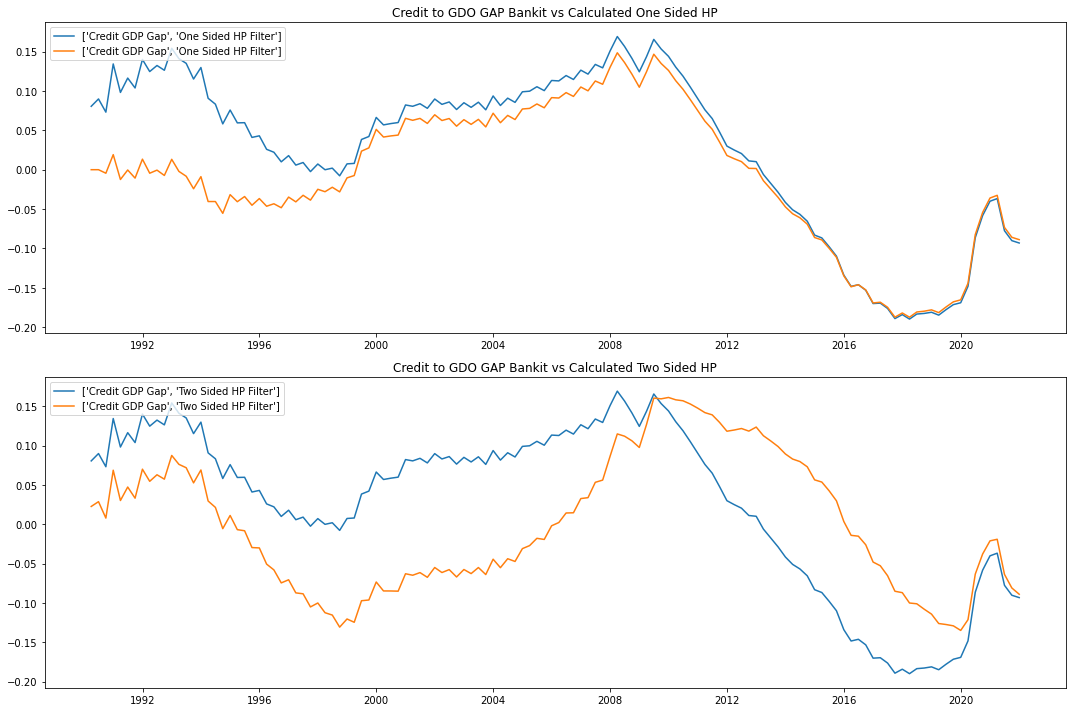

In [ ]:
VarName = 'CreditGDP'
Lambda = 400000
DF =  HP_Comparison(DF_BANKIT, VarName, Lambda)

In [ ]:
#last values of Cycle_1 (our HP-1s based GAP) converge to official values (CreditGDP_Gap)
DF.iloc[-10:,:][['CreditGDP_Gap','Cycle_1']]


,CreditGDP_Gap,Cycle_1
Date,,
2019-09-30,-0.171513,-0.167967
2019-12-31,-0.169118,-0.165436
2020-03-31,-0.148193,-0.144391
2020-06-30,-0.086323,-0.082418
2020-09-30,-0.058301,-0.054308
2020-12-31,-0.040101,-0.036033
2021-03-31,-0.036707,-0.032573
2021-06-30,-0.077548,-0.073357
2021-09-30,-0.090175,-0.085935


Eventually, we compare the behavior of our HP-1s using a shorter time series (we use a shorter window cutting the farthest tail).
We can see how with a shorter time series our HP-1S shows a weaker convergence

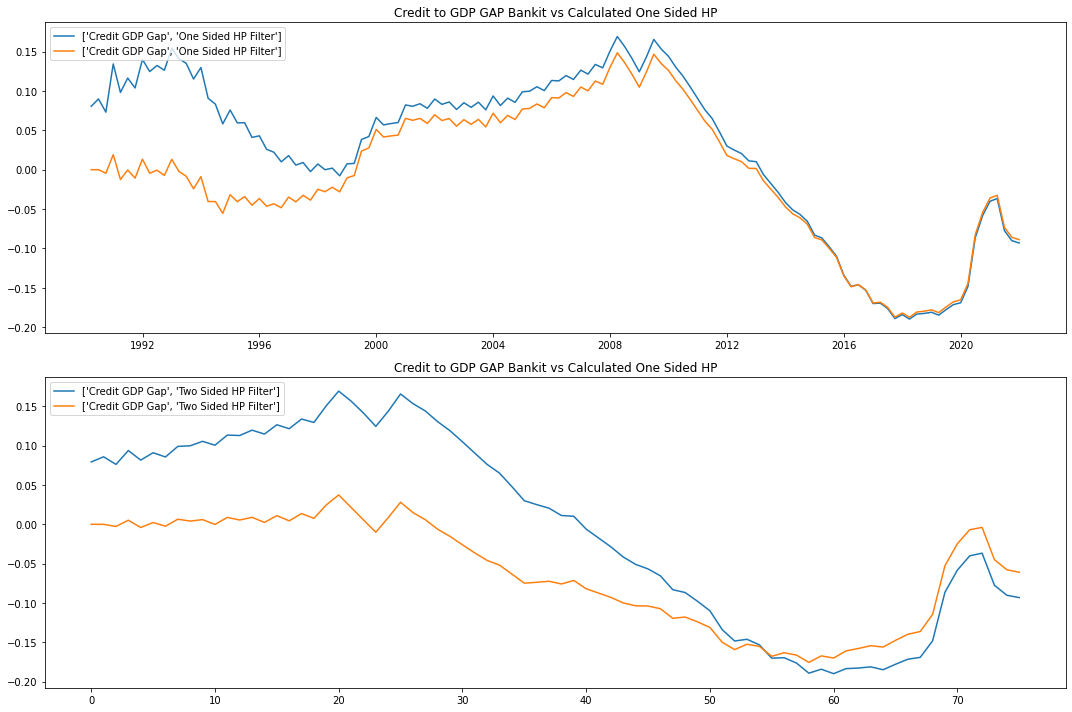

In [ ]:
DF['Data']=DF.index.values
Query_string = 'SELECT a.CreditGDP, a.CreditGDP_Gap from DF as a where strftime("%Y-%m-%d", a.Data) > "{}"'.format("2002-12-31")
DF_2 = ps.sqldf(Query_string,globals())
DF_2=Calc_HP(DF_2, VarName, Lambda)

fig, axs = plt.subplots(2,1,figsize=(15, 10))
axs[0].plot(DF[['CreditGDP_Gap', 'Cycle_1']], label = ['Credit GDP Gap', 'One Sided HP Filter'])
axs[0].set_title('Credit to GDP GAP Bankit vs Calculated One Sided HP')
axs[0].legend(loc='upper left')

axs[1].plot(DF_2[['CreditGDP_Gap', 'Cycle_1']], label = ['Credit GDP Gap', 'Two Sided HP Filter'])
axs[1].set_title('Credit to GDP GAP Bankit vs Calculated One Sided HP')
axs[1].legend(loc='upper left')

fig.tight_layout()

In [ ]:
def HP_Last_Value_Comparison(DF_IN, VarName, Lambda):
    import math
    mydict={}
    L0 = len(DF_IN[VarName])
    L1 =  L0-12
    for i in range(0,L1,1):
      DF = Calc_HP(DF_IN.iloc[i:,:], VarName, Lambda)
      mydict[DF.index[0]]= (abs(DF.iloc[-1,:].loc['CreditGDP_Gap']-DF.iloc[-1,:].loc['Cycle_1']),L0-i) 
    
    DF_LAST_DELTA = pd.DataFrame([mydict]).T.sort_index(ascending= False) 
    return DF_LAST_DELTA

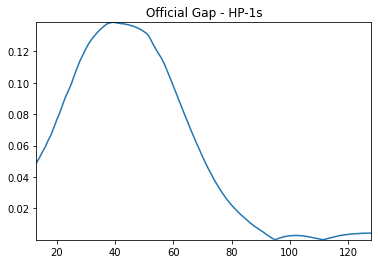

In [ ]:
X = HP_Last_Value_Comparison(DF_BANKIT, VarName, Lambda)
X.rename(columns ={0:'Delta'}, inplace=True)
X = pd.DataFrame([*X.Delta],columns = ['Delta','Obs'])
x=X.loc[:,'Obs']
y=X.loc[:,'Delta']
plt.plot(x, y)
plt.title("Official Gap - HP-1s")
plt.axis([min(x), max(x), min(y), max(y)])
#plt.axis([max(x), min(x), max(y), min(y)])
plt.show()

In [ ]:
#we use a widget to show the convergence to the official value
def wdg_HP_Last_Value_Comparison(obs=13):
    DF_IN = DF_BANKIT
    
    MinVal, MaxVal = (13, len(DF_IN[VarName]))
    
    if obs > MaxVal: 
        obs = MaxVal
    elif obs < MinVal: 
        obs = MinVal
    
    StartPoint = MaxVal-obs
    DF = Calc_HP(DF_IN.iloc[StartPoint:,:], VarName, Lambda)
    
    DF['ERROR'] = abs(DF.loc[:,'CreditGDP_Gap']-DF.loc[:,'Cycle_1'])
        
    fig, axs = plt.subplots(2,1,figsize=(15, 10))
    axs[0].plot(DF[['CreditGDP_Gap', 'Cycle_1']], label = ['Credit GDP Gap', 'One Sided HP Filter'])
    axs[0].set_title('Credit to GDP GAP Bankit vs Calculated One Sided HP')
    axs[0].legend(loc='upper left')

    axs[1].plot(DF[['ERROR']], label = ['ERROR'])
    axs[1].set_title('abs(Credit to GDP GAP Bankit - Calculated One Sided HP)')
    axs[1].legend(loc='upper left')

    fig.tight_layout()
    
           

In [ ]:
L1 = len(DF_BANKIT[VarName])
widgets.interact(wdg_HP_Last_Value_Comparison, obs=(0,L1, 1))

interactive(children=(IntSlider(value=13, description='obs', max=128), Output()), _dom_classes=('widget-intera…

<function __main__.wdg_HP_Last_Value_Comparison(obs=13)>